In [1]:
import numpy as np
import pandas as pd

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "12"

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

2024-06-24 15:16:41.982591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from utils import (
    create_plot,
    forecast_accuracy
)

In [6]:
# Check everything with Tensorflow works 
import sys

# import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-10.16-x86_64-i386-64bit
Tensor Flow Version: 2.12.0

Python 3.9.18 (main, Sep 11 2023, 08:20:50) 
[Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.4.1.post1
SciPy 1.12.0
GPU is available


In [7]:
metrics_ = pd.DataFrame()

### Loading the Dataset

In [8]:
ts_prices_btc = pd.read_csv("Data/Time_Series/prices/bitcoin_19_22.csv",index_col='date',parse_dates=['date'])

In [9]:
df = ts_prices_btc

In [10]:
df.head()

,price
date,
2019-01-01,3692.53
2019-01-02,3794.26
2019-01-03,3872.17
2019-01-04,3776.53
2019-01-05,3815.27


### Adding Features

In [11]:
n_lags = 14
for lag in range(1, n_lags + 1):
    df[f'price_lag_{lag}'] = df['price'].shift(lag)

In [12]:
window_sizes = [7, 14, 30]  # Window sizes for moving averages
for window_size in window_sizes:
    df[f'price_ma_{window_size}'] = df['price_lag_1'].rolling(window=window_size).mean()

In [13]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

In [14]:
df.isna().sum()

price            0
price_lag_1      1
price_lag_2      2
price_lag_3      3
price_lag_4      4
price_lag_5      5
price_lag_6      6
price_lag_7      7
price_lag_8      8
price_lag_9      9
price_lag_10    10
price_lag_11    11
price_lag_12    12
price_lag_13    13
price_lag_14    14
price_ma_7       7
price_ma_14     14
price_ma_30     30
day_of_week      0
month            0
year             0
dtype: int64

In [15]:
df = df[30:]

### Only Price Features

In [16]:
df.columns

Index(['price', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4',
       'price_lag_5', 'price_lag_6', 'price_lag_7', 'price_lag_8',
       'price_lag_9', 'price_lag_10', 'price_lag_11', 'price_lag_12',
       'price_lag_13', 'price_lag_14', 'price_ma_7', 'price_ma_14',
       'price_ma_30', 'day_of_week', 'month', 'year'],
      dtype='object')

In [17]:
df.head()

,price,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,price_lag_8,price_lag_9,price_lag_10,price_lag_11,price_lag_12,price_lag_13,price_lag_14,price_ma_7,price_ma_14,price_ma_30,day_of_week,month,year
date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,3457.88,3413.38,3432.22,3553.12,3563.61,3564.82,3565.64,3555.70,3571.27,3531.00,3539.17,3674.59,3597.79,3620.98,3597.65,3521.212857,3555.781429,3668.161333,3,1,2019
2019-02-01,3431.94,3457.88,3413.38,3432.22,3553.12,3563.61,3564.82,3565.64,3555.70,3571.27,3531.00,3539.17,3674.59,3597.79,3620.98,3507.238571,3545.797857,3660.339667,4,2,2019
2019-02-02,3464.49,3431.94,3457.88,3413.38,3432.22,3553.12,3563.61,3564.82,3565.64,3555.70,3571.27,3531.00,3539.17,3674.59,3597.79,3488.138571,3532.295000,3648.262333,5,2,2019
2019-02-03,3486.58,3464.49,3431.94,3457.88,3413.38,3432.22,3553.12,3563.61,3564.82,3565.64,3555.70,3571.27,3531.00,3539.17,3674.59,3473.805714,3522.773571,3634.673000,6,2,2019
2019-02-04,3454.03,3486.58,3464.49,3431.94,3457.88,3413.38,3432.22,3553.12,3563.61,3564.82,3565.64,3555.70,3571.27,3531.00,3539.17,3462.801429,3509.344286,3625.008000,0,2,2019


In [18]:
test_split=round(len(df)*0.40)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
val_split=round(len(df_for_testing)*0.50)
df_for_validation=df_for_testing[:-val_split]
df_for_testing=df[-val_split:]
print(f"Training Set: {df_for_training.shape}")
print(f"Validation Set: {df_for_validation.shape}")
print(f"Testing Set: {df_for_testing.shape}")

Training Set: (859, 21)
Validation Set: (286, 21)
Testing Set: (286, 21)


In [19]:
print(df_for_training.index[0],df_for_training.index[-1])
print(df_for_validation.index[0],df_for_validation.index[-1])
print(df_for_testing.index[0],df_for_testing.index[-1])

2019-01-31 00:00:00 2021-06-07 00:00:00
2021-06-08 00:00:00 2022-03-20 00:00:00
2022-03-21 00:00:00 2022-12-31 00:00:00


In [20]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled=scaler.transform(df_for_validation)
df_for_training_scaled.shape, df_for_validation_scaled.shape

((859, 21), (286, 21))

In [21]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,30)
valX,valY=createXY(df_for_validation_scaled,30)

In [22]:
df.shape

(1431, 21)

In [23]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(30,return_sequences=True,input_shape=(30,20)))
    grid_model.add(LSTM(30))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))
parameters = {'batch_size' : [16,20],
            'epochs' : [8,10],
            'optimizer' : ['adam'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

/var/folders/2l/h6ht9_t96fn33pfzbxcdp_dm0000gn/T/ipykernel_34287/2823166080.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))


In [24]:
grid_search = grid_search.fit(trainX,trainY)

2024-06-24 15:16:45.572998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-24 15:16:45.573083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-24 15:16:46.118660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:16:46.120219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

Epoch 1/8


2024-06-24 15:16:46.865847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:16:46.867410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:16:46.868693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0448

2024-06-24 15:16:53.584180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:16:53.585632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:16:53.586685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 8s 92ms/step - loss: 0.0448 - val_loss: 0.0185
Epoch 2/8
26/26 [==============================] - 1s 39ms/step - loss: 0.0085 - val_loss: 0.0143
Epoch 3/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0072 - val_loss: 0.0116
Epoch 4/8
26/26 [==============================] - 1s 37ms/step - loss: 0.0068 - val_loss: 0.0102
Epoch 5/8
26/26 [==============================] - 1s 41ms/step - loss: 0.0055 - val_loss: 0.0112
Epoch 6/8
26/26 [==============================] - 1s 42ms/step - loss: 0.0048 - val_loss: 0.0130
Epoch 7/8
26/26 [==============================] - 1s 49ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 8/8
26/26 [==============================] - 1s 49ms/step - loss: 0.0046 - val_loss: 0.0113


2024-06-24 15:17:02.423511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:02.425223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:02.426352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 17ms/step - loss: 0.0022


2024-06-24 15:17:03.848128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:03.849647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:03.850704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:17:04.291160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:04.292774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:04.293873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0022

2024-06-24 15:17:09.219882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:09.221338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:09.222362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 6s 85ms/step - loss: 0.0022 - val_loss: 0.0993
Epoch 2/8
26/26 [==============================] - 1s 38ms/step - loss: 7.0293e-04 - val_loss: 0.0996
Epoch 3/8
26/26 [==============================] - 1s 37ms/step - loss: 4.3987e-04 - val_loss: 0.0836
Epoch 4/8
26/26 [==============================] - 1s 37ms/step - loss: 3.5661e-04 - val_loss: 0.1036
Epoch 5/8
26/26 [==============================] - 1s 37ms/step - loss: 3.4772e-04 - val_loss: 0.0967
Epoch 6/8
26/26 [==============================] - 1s 37ms/step - loss: 3.1465e-04 - val_loss: 0.0775
Epoch 7/8
26/26 [==============================] - 1s 37ms/step - loss: 2.7023e-04 - val_loss: 0.0907
Epoch 8/8
26/26 [==============================] - 1s 37ms/step - loss: 2.4937e-04 - val_loss: 0.0897


2024-06-24 15:17:17.095307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:17.096739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:17.097764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 23s - loss: 4.1546e-04

2024-06-24 15:17:17.670788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 15ms/step - loss: 0.0382


2024-06-24 15:17:18.395654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:18.397097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:18.398126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:17:18.835860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:18.837547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:18.838717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0439

2024-06-24 15:17:23.498339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:23.499755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:23.500786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 6s 84ms/step - loss: 0.0439 - val_loss: 0.0131
Epoch 2/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0082 - val_loss: 0.0103
Epoch 3/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0066 - val_loss: 0.0114
Epoch 4/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0061 - val_loss: 0.0087
Epoch 5/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0053 - val_loss: 0.0085
Epoch 6/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0041 - val_loss: 0.0072
Epoch 7/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0041 - val_loss: 0.0084
Epoch 8/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0039 - val_loss: 0.0121
Epoch 9/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 10/10
26/26 [==============================] - 1s 36ms/step - loss: 0.0039 - val_loss: 0.0065


2024-06-24 15:17:33.366822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:33.368304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:33.369320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 15ms/step - loss: 5.2380e-04


2024-06-24 15:17:34.685843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:34.687358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:34.688517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:17:35.548036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:35.549725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:35.550902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0028

2024-06-24 15:17:40.252329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:40.253883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:40.255060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 6s 90ms/step - loss: 0.0028 - val_loss: 0.1777
Epoch 2/10
26/26 [==============================] - 1s 38ms/step - loss: 5.6202e-04 - val_loss: 0.0951
Epoch 3/10
26/26 [==============================] - 1s 38ms/step - loss: 4.2200e-04 - val_loss: 0.1257
Epoch 4/10
26/26 [==============================] - 1s 38ms/step - loss: 3.5004e-04 - val_loss: 0.1189
Epoch 5/10
26/26 [==============================] - 1s 43ms/step - loss: 3.0838e-04 - val_loss: 0.1239
Epoch 6/10
26/26 [==============================] - 1s 37ms/step - loss: 2.9896e-04 - val_loss: 0.1337
Epoch 7/10
26/26 [==============================] - 1s 37ms/step - loss: 2.8356e-04 - val_loss: 0.1436
Epoch 8/10
26/26 [==============================] - 1s 38ms/step - loss: 2.5163e-04 - val_loss: 0.1453
Epoch 9/10
26/26 [==============================] - 1s 37ms/step - loss: 2.4827e-04 - val_loss: 0.1512
Epoch 10/10
26/26 [==============================] - 1s 37ms/step - loss: 2.6239e-04 - v

2024-06-24 15:17:50.372167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:50.373554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:50.374709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 2s 30ms/step - loss: 0.0692


2024-06-24 15:17:52.089570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:52.091205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:52.092345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:17:52.568443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:52.570387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:52.571550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0287

2024-06-24 15:17:57.683191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:17:57.684738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:17:57.685821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 115ms/step - loss: 0.0287 - val_loss: 0.0124
Epoch 2/8
21/21 [==============================] - 1s 45ms/step - loss: 0.0079 - val_loss: 0.0165
Epoch 3/8
21/21 [==============================] - 1s 46ms/step - loss: 0.0065 - val_loss: 0.0096
Epoch 4/8
21/21 [==============================] - 1s 45ms/step - loss: 0.0059 - val_loss: 0.0142
Epoch 5/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 6/8
21/21 [==============================] - 1s 41ms/step - loss: 0.0047 - val_loss: 0.0187
Epoch 7/8
21/21 [==============================] - 1s 41ms/step - loss: 0.0041 - val_loss: 0.0074
Epoch 8/8
21/21 [==============================] - 0s 16ms/step - loss: 0.0061


2024-06-24 15:18:05.679810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:05.681176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:05.682273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:18:06.662348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:06.663983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:06.665110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0017

2024-06-24 15:18:11.403489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:11.404943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:11.406203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 109ms/step - loss: 0.0017 - val_loss: 0.0788
Epoch 2/8
21/21 [==============================] - 1s 42ms/step - loss: 6.7822e-04 - val_loss: 0.1200
Epoch 3/8
21/21 [==============================] - 1s 57ms/step - loss: 4.9809e-04 - val_loss: 0.1115
Epoch 4/8
21/21 [==============================] - 1s 42ms/step - loss: 3.8486e-04 - val_loss: 0.0939
Epoch 5/8
21/21 [==============================] - 1s 42ms/step - loss: 3.2474e-04 - val_loss: 0.0989
Epoch 6/8
21/21 [==============================] - 1s 42ms/step - loss: 3.3827e-04 - val_loss: 0.1024
Epoch 7/8
21/21 [==============================] - 1s 42ms/step - loss: 2.8647e-04 - val_loss: 0.1127
Epoch 8/8
21/21 [==============================] - 0s 16ms/step - loss: 0.0382


2024-06-24 15:18:19.387606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:19.389201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:19.390264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:18:19.834446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:19.836148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:19.837306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0803

2024-06-24 15:18:24.598931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:24.600520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:24.601650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 110ms/step - loss: 0.0803 - val_loss: 0.0487
Epoch 2/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0121 - val_loss: 0.0129
Epoch 3/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0084 - val_loss: 0.0112
Epoch 4/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0069 - val_loss: 0.0130
Epoch 5/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0061 - val_loss: 0.0179
Epoch 6/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 7/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0047 - val_loss: 0.0120
Epoch 8/10
21/21 [==============================] - 1s 44ms/step - loss: 0.0049 - val_loss: 0.0159
Epoch 9/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 10/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0036


2024-06-24 15:18:33.981301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:33.982798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:33.983932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:18:34.854405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:34.856180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:34.857499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0044

2024-06-24 15:18:39.675884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:39.677401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:39.678576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 112ms/step - loss: 0.0044 - val_loss: 0.2214
Epoch 2/10
21/21 [==============================] - 1s 46ms/step - loss: 7.4506e-04 - val_loss: 0.1497
Epoch 3/10
21/21 [==============================] - 1s 41ms/step - loss: 5.5675e-04 - val_loss: 0.1375
Epoch 4/10
21/21 [==============================] - 1s 41ms/step - loss: 4.7958e-04 - val_loss: 0.1447
Epoch 5/10
21/21 [==============================] - 1s 41ms/step - loss: 4.1200e-04 - val_loss: 0.1366
Epoch 6/10
21/21 [==============================] - 1s 41ms/step - loss: 3.5566e-04 - val_loss: 0.1470
Epoch 7/10
21/21 [==============================] - 1s 41ms/step - loss: 3.1934e-04 - val_loss: 0.1477
Epoch 8/10
21/21 [==============================] - 1s 41ms/step - loss: 3.0644e-04 - val_loss: 0.1461
Epoch 9/10
21/21 [==============================] - 1s 41ms/step - loss: 2.8596e-04 - val_loss: 0.1558
Epoch 10/10
21/21 [==============================] - 0s 17ms/step - loss: 0.0564


2024-06-24 15:18:49.133914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:49.135474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:49.136607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:18:49.591545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:49.593257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:49.594562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

52/52 [==============================] - ETA: 0s - loss: 0.0162

2024-06-24 15:18:55.523454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:18:55.525241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:18:55.526398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

52/52 [==============================] - 7s 61ms/step - loss: 0.0162 - val_loss: 0.0108
Epoch 2/8
52/52 [==============================] - 2s 35ms/step - loss: 0.0039 - val_loss: 0.0090
Epoch 3/8
52/52 [==============================] - 2s 34ms/step - loss: 0.0033 - val_loss: 0.0118
Epoch 4/8
52/52 [==============================] - 2s 44ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 5/8
52/52 [==============================] - 2s 34ms/step - loss: 0.0026 - val_loss: 0.0128
Epoch 6/8
52/52 [==============================] - 2s 38ms/step - loss: 0.0028 - val_loss: 0.0122
Epoch 7/8
52/52 [==============================] - 2s 34ms/step - loss: 0.0025 - val_loss: 0.0066
Epoch 8/8
52/52 [==============================] - 2s 34ms/step - loss: 0.0021 - val_loss: 0.0057


In [25]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 8, 'optimizer': 'adam'}

In [26]:
model_only_price=grid_search.best_estimator_.model

In [27]:
model_only_price.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 30)            6120      
                                                                 
 lstm_17 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 13,471
Trainable params: 13,471
Non-trainable params: 0
_________________________________________________________________


In [28]:
df_for_validation[-30:].shape, df_for_validation[-30:].index[0]

((30, 21), Timestamp('2022-02-19 00:00:00'))

In [29]:
df_for_testing = pd.concat([df_for_validation[-30:],df_for_testing])

In [30]:
df_for_testing.shape

(316, 21)

In [31]:
df_for_testing_scaled = scaler.transform(df_for_testing)
testX,testY=createXY(df_for_testing_scaled,30)
pred = model_only_price.predict(testX)
prediction_copies_array = np.repeat(pred,21, axis=-1)
predicted_prices = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(pred),21)))[:,0]

2024-06-24 15:19:10.083062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:19:10.084691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:19:10.085876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/9 [==>...........................] - ETA: 8s

2024-06-24 15:19:10.655348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 24ms/step


In [32]:
df_for_testing[30:].shape,predicted_prices.shape

((286, 21), (286,))

In [33]:
n_df= pd.DataFrame()
n_df.index = df_for_testing[30:].index
n_df['price'] = predicted_prices

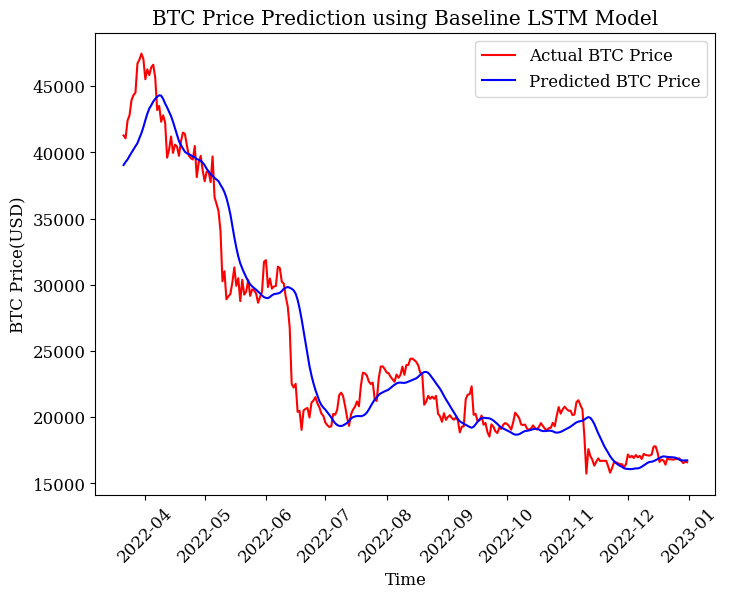

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(df_for_testing['price'].iloc[30:], color = 'red', label = 'Actual BTC Price')
plt.plot(n_df['price'], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction using Baseline LSTM Model')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('BTC Price(USD)')
plt.legend()
plt.show()

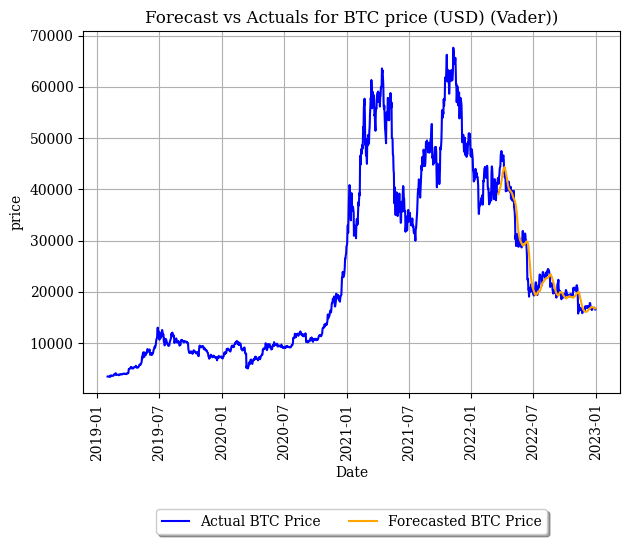

In [35]:
create_plot(n_df['price'],df['price'], 'BTC', 'Vader')

In [36]:
res = forecast_accuracy(n_df['price'], df_for_testing['price'].iloc[30:],['BTC_Baseline'])
res

,MAE,MAPE,MSE,RMSE
BTC_Baseline,1491.59649,6.048326,4.886125e+06,2210.458028


In [38]:
model_only_price.save("BTC_Baseline_LSTModel.keras")